In [33]:
import numpy as np 
import pandas as pd 

from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [34]:
dataTrain = pd.read_csv('./data/twitter_train.csv')
dataTrain.columns = ["tweet id", "entity", "sentiment", "content"]
dataTrain.drop(["tweet id", "entity"],inplace=True, axis=1)

dataTrain.head()

,sentiment,content
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...


In [35]:
Le = LabelEncoder()
dataTrain["encodedSentiment"] = Le.fit_transform(dataTrain["sentiment"])
dataTrain.head()

,sentiment,content,encodedSentiment
0,Positive,I am coming to the borders and I will kill you...,3
1,Positive,im getting on borderlands and i will kill you ...,3
2,Positive,im coming on borderlands and i will murder you...,3
3,Positive,im getting on borderlands 2 and i will murder ...,3
4,Positive,im getting into borderlands and i can murder y...,3


In [36]:
dataTrain.isnull().sum()

sentiment             0
content             686
encodedSentiment      0
dtype: int64

In [37]:
dataTrain.dropna(inplace=True)

In [38]:
dataTrain.isnull().sum()

sentiment           0
content             0
encodedSentiment    0
dtype: int64

In [39]:
Le.classes_

array(['Irrelevant', 'Negative', 'Neutral', 'Positive'], dtype=object)

In [42]:
dataTrain["sentiment"].value_counts()

sentiment
Negative      22358
Positive      20654
Neutral       18108
Irrelevant    12875
Name: count, dtype: int64

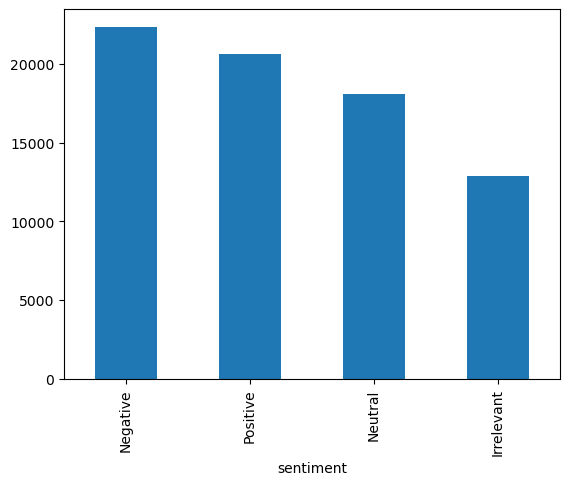

In [44]:
distr = dataTrain["sentiment"].value_counts()
plot = distr.plot(kind="bar")